# Module 05 Project Overview

The purpose of this project is to examine the relationship between hyperglycemic tests and hospital readmittance rates of patients with diabetes as a diagnosis. The model will attempt to predict which patients are likely to be readmitted for complications and categorized as being hospitalized within a month, more than a month from most recent discharge, and never. This model and similar models can change when testing is administered, possibly resulting in earlier diagnosis and preventative measures to be taken during the initial treatment period to avoid readmittance, lowering healthcare costs for both patient and hospital. 

This machine learning project is a supervised, multi-class classification problem.

You'll find the accompanying biomedical research paper with label descriptions and further information <a href="http://dx.doi.org/10.1155/2014/781670">here.</a>

# Loading Data

In [216]:
# standard imports
import pandas as pd
import numpy as np
import pandas_profiling

import warnings
warnings.filterwarnings("ignore")

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns

# modeling
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, recall_score, classification_report, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier

# resampling
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [3]:
raw_df = pd.read_csv("diabetes_data.csv")
df = pd.read_csv("diabetes_data.csv")

In [4]:
df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital    ...     citoglipton insulin  glyburide-metformin  \
0                 1    ...              No      No                   No   
1                 3    ...              No      Up                   No   
2                 2    ...              No      No                   No   
3                 2    ...              No      Up                   No   
4                 1    ...              No  Steady                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

   metformin-pioglitazone  change diabetesMed readmitted  
0                      No      No          No         NO  
1                      No      Ch         Yes        >30  
2                      No      No         Yes         NO  
3                      No      Ch         Yes         NO  
4                      No      Ch         Yes         NO  

[5 rows x 50 columns]

In [5]:
len(df)

101766

In [6]:
#df.profile_report()

# Preprocessing

In [7]:
df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital    ...     citoglipton insulin  glyburide-metformin  \
0                 1    ...              No      No                   No   
1                 3    ...              No      Up                   No   
2                 2    ...              No      No                   No   
3                 2    ...              No      Up                   No   
4                 1    ...              No  Steady                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

   metformin-pioglitazone  change diabetesMed readmitted  
0                      No      No          No         NO  
1                      No      Ch         Yes        >30  
2                      No      No         Yes         NO  
3                      No      Ch         Yes         NO  
4                      No      Ch         Yes         NO  

[5 rows x 50 columns]

In [8]:
df.drop(['weight','payer_code', 'citoglipton','examide'], inplace=True, axis=1) #Dropping weight since too few rows have actual values
# Payer Code unnecessary for classification task
#Rejected citoglipton and examide - all "no"

Because the medical specialty of the service provider could have influence on whether the H1bAlc test was performed, missing values will be replace with 'Unknown'.

In [9]:
df['medical_specialty'].replace(to_replace='?', value='Unknown', inplace=True)

In [10]:
df.race.value_counts(normalize=True)

Caucasian          0.747784
AfricanAmerican    0.188766
?                  0.022336
Hispanic           0.020017
Other              0.014799
Asian              0.006299
Name: race, dtype: float64

The following code replaces missing values in the race column with a random choice aligned with the probabilities of all other race options.

In [11]:
df['race'] = df['race'].apply(lambda x: np.random.choice(['Caucasian', 'AfricanAmerican','Hispanic', 'Other', 'Asian'], p=[0.76, 0.19, 0.02, 0.02, 0.01]) if x == '?' else x)

In [12]:
df.race.value_counts(normalize=True) #Confirming appropriate distribution

Caucasian          0.764705
AfricanAmerican    0.193178
Hispanic           0.020419
Other              0.015270
Asian              0.006427
Name: race, dtype: float64

In [13]:
df.gender.value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [14]:
df = df[df.gender != 'Unknown/Invalid'] #dropping the three unknown gender rows

Due to my lack of medical knowledge, the following function will take in a column of ICD9 codes and replace them with the verbal diagnosis. This will help my understanding of the data. 

In [15]:
def diagnose(x):
    if (x >= 390) and (x <= 459) or (x == 785):
        return 'circulatory'
    
    elif (x >= 460) and (x <= 519) or (x == 786):
        return'respiratory'
    
    elif (x >= 520) and (x <= 579) or (x == 787):
        return 'digestive'
    
    elif (x >= 250) and (x <= 251):
        return 'diabetes'
    
    elif (x >= 800) and (x <= 999):
        return 'injury_poisoning'
    
    elif (x >= 710) and (x <= 739): 
        return 'musculoskeletal'
    
    elif (x >= 580) and (x <= 629) or (x == 788): 
        return 'genitourinary'
    
    elif (x >= 140) and (x <= 239): 
         return'neoplasms'
    
    elif (x >= 240) and (x <= 279): 
         return'endocrine_nutrition_metabolic'
    
    elif (x >= 680) and (x <= 709) or (x == 782): 
         return'skin_disease'
    
    elif (x >= 1) and (x <= 139): 
         return'infection_parasites'
    
    elif (x >= 290) and (x <= 319): 
        return 'mental'
    
    elif (x >= 0) and (x <1) or (x == 786): 
        return 'external_injury'
    
    elif (x >= 280) and (x <= 289):
        return 'blood'
    
    elif (x >= 320) and (x <= 359): 
        return 'nervous'
    
    elif (x >= 630) and (x <= 679):
        return 'pregnancy_childbirth'
    
    elif (x >= 360) and (x <= 389): 
        return 'sensory'
    
    elif (x >= 740) and (x <= 759):
        return 'congenital'
    
    elif (x >= 789) and (x <= 799) or (x == 780) or (x == 781) or (x == 784) or (x == 783):
        return 'other'
    else:
        return x

In [16]:
for col in ['diag_1', 'diag_2', 'diag_3']: 
    df[col] = [x.replace('V', "0.") for x in df[col]]
    df[col] = [x.replace('E', '0.') for x in df[col]]
    df[col] = [x.replace('?', '0') for x in df[col]]
    df[col] = df[col].astype(float)

In [17]:
df.diag_1 = df.diag_1.apply(diagnose)
df.diag_2 = df.diag_2.apply(diagnose)
df.diag_3 = df.diag_3.apply(diagnose)

In [18]:
for col in ['diag_1', 'diag_2', 'diag_3']:
    print(col, df[col].unique(), '\n\n')

diag_1 ['diabetes' 'endocrine_nutrition_metabolic' 'pregnancy_childbirth'
 'infection_parasites' 'neoplasms' 'circulatory' 'respiratory'
 'injury_poisoning' 'skin_disease' 'musculoskeletal' 'digestive'
 'external_injury' 'genitourinary' 'mental' 'other' 'nervous' 'blood'
 'sensory' 'congenital'] 


diag_2 ['external_injury' 'diabetes' 'neoplasms' 'circulatory' 'respiratory'
 'blood' 'injury_poisoning' 'musculoskeletal' 'genitourinary'
 'infection_parasites' 'endocrine_nutrition_metabolic' 'digestive'
 'skin_disease' 'nervous' 'other' 'mental' 'pregnancy_childbirth'
 'congenital' 'sensory'] 


diag_3 ['external_injury' 'endocrine_nutrition_metabolic' 'circulatory'
 'diabetes' 'infection_parasites' 'respiratory' 'injury_poisoning'
 'neoplasms' 'genitourinary' 'musculoskeletal' 'other' 'digestive'
 'skin_disease' 'mental' 'congenital' 'nervous' 'sensory'
 'pregnancy_childbirth' 'blood'] 




Keeping in line with the research paper, for patients who have had multiple encounters, each encounter past the first has been removed as they cannot be deemed statistically independent. 

In [19]:
df = df.drop_duplicates(subset=['patient_nbr'], keep='first')

# Exploratory Data Analysis

In [20]:
target = df.readmitted
features = df.drop('readmitted', axis=1)

In [21]:
df.profile_report()

Since the problem we're trying to solve is classifying and predicting patients that received the H1BA1c hyperglycemia test and the likelihood that they will be readmitted for complications, we'll take a look at readmittance rates for those who have received and have not received the test. 

In [22]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [23]:
tested = df.loc[df.A1Cresult != 'None']
not_tested = df.loc[df.A1Cresult == 'None']

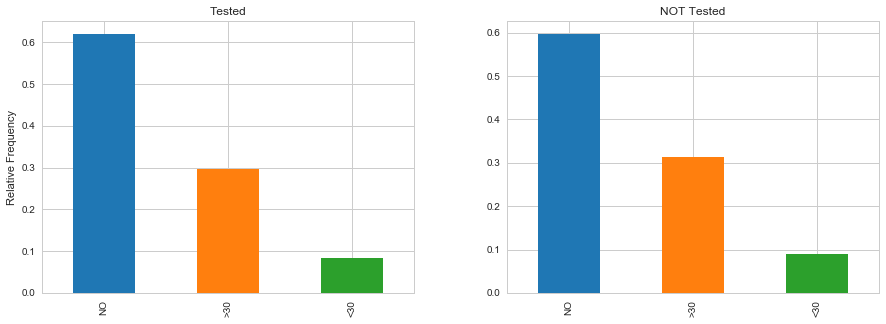

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
tested.readmitted.value_counts(normalize=True).plot(kind='bar', ax=ax1)
not_tested.readmitted.value_counts(normalize=True).plot(kind='bar', ax=ax2)
ax1.set_ylabel('Relative Frequency')
plt.subplots_adjust(wspace=.25)
ax1.set_title("Tested")
ax2.set_title("NOT Tested")

plt.show()

As you can see in the plots above, whether or not patients were tested for hyperglycemia, 40% of patients were readmitted. You can also observe the class disparity which will need to be remedied before modeling can begin.

Female    38025
Male      33490
Name: gender, dtype: int64


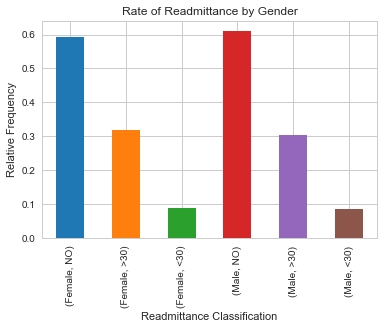

In [25]:
df.groupby(df.gender).readmitted.value_counts(normalize=True).plot(kind='bar', stacked=True)
plt.title('Rate of Readmittance by Gender')
plt.xlabel('Readmittance Classification')
plt.ylabel('Relative Frequency');
print(df.gender.value_counts())

More African American and Caucasian women are readmitted than men, however  , and both men and women are more often not readmitted, and lease likely to be readmitted within the thirty days following discharge. 

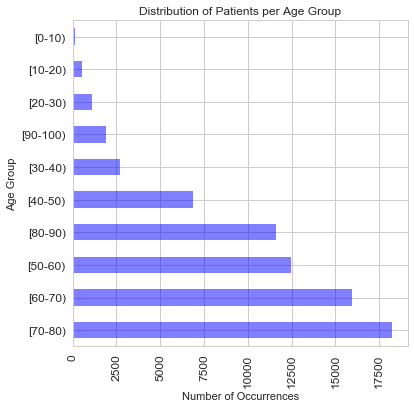

In [26]:
fig = plt.figure(figsize=(6,6))

df.age.value_counts().plot(kind='barh', color='blue', alpha=.5)
plt.title('Distribution of Patients per Age Group')
plt.ylabel('Age Group')
plt.xticks(rotation='vertical', size='large')
plt.yticks(size='large')
plt.xlabel('Number of Occurrences');

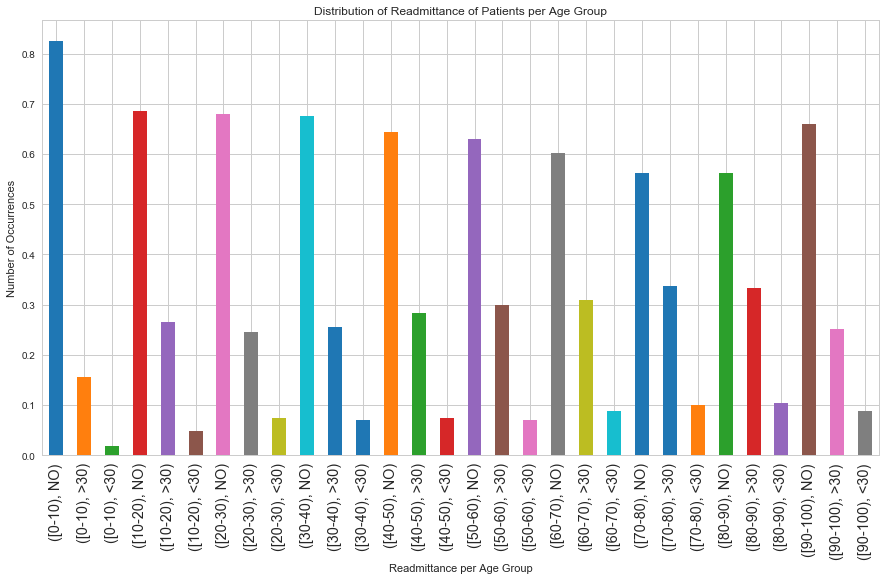

In [27]:
fig = plt.figure(figsize=(15,8))
age_df = df.groupby(df.age)

age_df.readmitted.value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of Readmittance of Patients per Age Group')
plt.xlabel('Readmittance per Age Group')
plt.xticks(rotation='vertical', size='x-large')
plt.ylabel('Number of Occurrences');

If you look closely, there is a general downward trend as patients increase in age for those who are not readmitted, while the rate of readmittance increases with age. There is another increase for patients who are 90-100 years old, though that may be due to the patient expiring or moving to hospice care.  

In [28]:
diabetes2 = tested.loc[tested['diag_2']=='diabetes'] 
diabetes2.loc[diabetes2['A1Cresult'] != 'None'].readmitted.value_counts(normalize=True)*100

NO     63.397129
>30    28.803828
<30     7.799043
Name: readmitted, dtype: float64

In [29]:
tested.groupby('diag_1').A1Cresult.value_counts(normalize=True)*100

diag_1                         A1Cresult
blood                          Norm         52.857143
                               >8           31.428571
                               >7           15.714286
circulatory                    >8           46.636012
                               Norm         29.235237
                               >7           24.128751
congenital                     >8           57.142857
                               >7           28.571429
                               Norm         14.285714
diabetes                       >8           73.493976
                               Norm         16.530120
                               >7            9.975904
digestive                      >8           42.216981
                               Norm         32.900943
                               >7           24.882075
endocrine_nutrition_metabolic  >8           43.333333
                               Norm         32.500000
                               >7        

# Machine Learning Modeling

In [30]:
df.readmitted.value_counts(normalize=True)

NO     0.601021
>30    0.310984
<30    0.087996
Name: readmitted, dtype: float64

In [31]:
features.drop(['encounter_id','patient_nbr'], inplace=True, axis=1) #eliminating irrelevant and correlated ordinal data 

In [32]:
features = features.astype('category', inplace=True)
features = pd.get_dummies(features, drop_first = True)
features.columns = features.columns.str.replace("[", "_")
len(features.columns)

523

## Resampling

In order for our models to work properly, we'll need to address the class imbalance of our target variable. I'll try three different resampling methods after first separating into the training and testing sets, setting a baseline model, and identifying the performance metric.

In [33]:
target= target.replace(['<30','>30'], 'YES')
print(target.value_counts())
print(target.value_counts(normalize=True)*100)

NO     42982
YES    28533
Name: readmitted, dtype: int64
NO     60.102076
YES    39.897924
Name: readmitted, dtype: float64


In [34]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=.2)

In [35]:
log = LogisticRegression().fit(x_train, y_train)
 
# Predict on training set
preds = log.predict(x_test)

# Checking accuracy
print('Accuracy Score: ', accuracy_score(y_test, preds),'\n\n')
print('Averaged Recall Score: ', recall_score(y_test, preds, average='weighted'), '\n\n')
    
log_report = classification_report(y_test, preds)
print(classification_report(y_test, preds))
# Checking unique values
predictions = pd.DataFrame(preds)
print(f'Distribution of Classifications (%)')
predictions[0].value_counts(normalize=True) *100
  

Accuracy Score:  0.6401454240369153 


Averaged Recall Score:  0.6401454240369153 


              precision    recall  f1-score   support

          NO       0.66      0.85      0.74      8638
         YES       0.58      0.32      0.41      5665

    accuracy                           0.64     14303
   macro avg       0.62      0.58      0.58     14303
weighted avg       0.63      0.64      0.61     14303

Distribution of Classifications (%)


NO     78.591904
YES    21.408096
Name: 0, dtype: float64

Not the best scores. Because of the class imbalance, the model is favoring 'NO' but our goal is to prevent patients from being readmitted. 

Our goal for the model will be to reduce false negatives by optimizing for recall. Let's compare Random Forests classification method against logistic regression.

In [36]:
rf = RandomForestClassifier().fit(x_train, y_train)
 
# Predict on training set
preds = rf.predict(x_test)

# Checking accuracy
print('Accuracy Score: ', accuracy_score(y_test, preds),'\n\n')
print('Averaged Recall Score: ', recall_score(y_test, preds, average='weighted'), '\n\n')
    
print(classification_report(y_test, preds))
# Checking unique values
predictions = pd.DataFrame(preds)
print(f'Distribution of Classifications (%)')
predictions[0].value_counts(normalize=True) *100

Accuracy Score:  0.609172900790044 


Averaged Recall Score:  0.609172900790044 


              precision    recall  f1-score   support

          NO       0.63      0.83      0.72      8638
         YES       0.51      0.27      0.35      5665

    accuracy                           0.61     14303
   macro avg       0.57      0.55      0.54     14303
weighted avg       0.59      0.61      0.57     14303

Distribution of Classifications (%)


NO     79.200168
YES    20.799832
Name: 0, dtype: float64

The distribution of classes improved, but recall and f1 scores decreased. We'll move forward with our resampling methods and compare the results of the logistical regression model. 

### Oversampling the Minority

In [37]:
# Returning to one dataframe
train = pd.concat([x_train, y_train], axis=1)

# Separating classes
not_readmitted = train[train.readmitted == 'NO']
readmitted = train[train.readmitted == 'YES']

cols = readmitted.columns
# Resampling minority classes
readmitted = resample(readmitted, 
                              replace=True, 
                              n_samples=len(not_readmitted),
                              random_state=42)

# Returning to new training set
oversample_train = pd.concat([not_readmitted, readmitted])

oversample_train.readmitted.value_counts(normalize=True)

YES    0.5
NO     0.5
Name: readmitted, dtype: float64

Now that we've upsampled our minority classes and each class is equal in size, we can refit the base model on the balanced data. 

In [38]:
oversample_x_train = oversample_train.drop('readmitted', axis=1)
oversample_y_train = oversample_train.readmitted

oversample_log = LogisticRegression().fit(oversample_x_train, oversample_y_train)
 
# Predict on training set
oversample_preds = oversample_log.predict(x_test)

# Checking accuracy
print('Accuracy Score: ', accuracy_score(y_test, oversample_preds),'\n\n')
print('Averaged Recall Score: ', recall_score(y_test, oversample_preds, average='weighted'), '\n\n')
    
print(classification_report(y_test, oversample_preds))
# Checking unique values
predictions = pd.DataFrame(oversample_preds)
print(f'Distribution of Classifications (%)')
predictions[0].value_counts(normalize=True) *100

Accuracy Score:  0.6174229182688946 


Averaged Recall Score:  0.6174229182688946 


              precision    recall  f1-score   support

          NO       0.71      0.62      0.66      8638
         YES       0.51      0.61      0.56      5665

    accuracy                           0.62     14303
   macro avg       0.61      0.62      0.61     14303
weighted avg       0.63      0.62      0.62     14303

Distribution of Classifications (%)


NO     53.261554
YES    46.738446
Name: 0, dtype: float64

Accuracy decreased, but the f1 scores of the readmitted classes did improve slightly. However, our goal is to reduce the number of false negatives, which can be reached by a higher recall. Next, we'll look at downsampling. 

### Undersampling the Majority

In [39]:
undersample = resample(not_readmitted, 
                              replace=True, 
                              n_samples=len(readmitted),
                              random_state=42)


# Returning to new training set
undersample_train = pd.concat([readmitted, undersample])

undersample_train.readmitted.value_counts(normalize=True)

YES    0.5
NO     0.5
Name: readmitted, dtype: float64

In [40]:
undersample_x_train = undersample_train.drop('readmitted', axis=1)
undersample_y_train = undersample_train.readmitted

undersample_log = LogisticRegression().fit(undersample_x_train, undersample_y_train)
 
# Predict on training set
undersample_preds = undersample_log.predict(x_test)

# Checking accuracy
print('Accuracy Score: ', accuracy_score(y_test, undersample_preds),'\n\n')
print('Averaged Recall Score: ', recall_score(y_test, undersample_preds, average='weighted'), '\n\n')
    
print(classification_report(y_test, undersample_preds))
# Checking unique values
predictions = pd.DataFrame(undersample_preds)
print(f'Distribution of Classifications (%)')
predictions[0].value_counts(normalize=True) *100

Accuracy Score:  0.6139271481507376 


Averaged Recall Score:  0.6139271481507376 


              precision    recall  f1-score   support

          NO       0.71      0.62      0.66      8638
         YES       0.51      0.60      0.55      5665

    accuracy                           0.61     14303
   macro avg       0.61      0.61      0.61     14303
weighted avg       0.63      0.61      0.62     14303

Distribution of Classifications (%)


NO     53.079773
YES    46.920227
Name: 0, dtype: float64

In [ ]:
print(log_report)

This model performed slightly better. While recall dropped .02 points for the weighted average, the f1 score did increase and the distribution of the classifications is more similar than oversampling. We'll try one more technique before moving on. 

### SMOTE (Synthetic Minority Oversampling Technique)

SMOTE is a nearest-neighbors algorithm that synthesizes data to supplement the real minority data for an even more robust training dataset.

In [87]:
sm = SMOTE(random_state=42, sampling_strategy='minority')
smote_x_train, smote_y_train = sm.fit_resample(x_train, y_train)

In [90]:
smote_x_train = pd.DataFrame(smote_x_train, columns = x_train.columns)
smote_y_train = pd.DataFrame(smote_y_train, columns = ['readmitted'])

In [43]:
smote_log = LogisticRegression().fit(smote_x_train, smote_y_train)
 
# Predict on training set
smote_preds = smote_log.predict(x_test)

# Checking accuracy
print('Accuracy Score: ', accuracy_score(y_test, smote_preds),'\n\n')
print('Averaged Recall Score: ', recall_score(y_test, smote_preds, average='weighted'), '\n\n')
    
print(classification_report(y_test, smote_preds))
# Checking unique values
predictions = pd.DataFrame(smote_preds)
print(f'Distribution of Classifications (%)')
predictions[0].value_counts(normalize=True) *100

Accuracy Score:  0.6428721247290778 


Averaged Recall Score:  0.6428721247290778 


              precision    recall  f1-score   support

          NO       0.66      0.85      0.74      8638
         YES       0.59      0.32      0.42      5665

    accuracy                           0.64     14303
   macro avg       0.62      0.59      0.58     14303
weighted avg       0.63      0.64      0.61     14303

Distribution of Classifications (%)


NO     78.487031
YES    21.512969
Name: 0, dtype: float64

SMOTE seems to have the higher overall recall and accuracy scores. At this point, we'll move forward with the SMOTE resampled data as our training set. 

## Pipelines

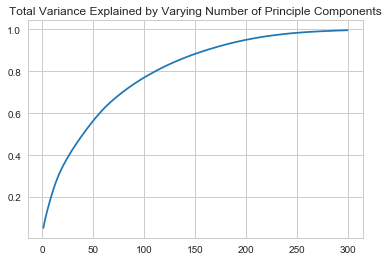

In [44]:
pca = PCA(n_components=300, whiten=True)
X_pca_train = pca.fit_transform(smote_x_train)

plt.plot(range(1,301), pca.explained_variance_ratio_.cumsum())
plt.title('Total Variance Explained by Varying Number of Principle Components');

In [47]:
# Decision Tree Pipeline
tree_pipe = Pipeline([('pca', PCA(n_components=250)),
                ('tree', tree.DecisionTreeClassifier(random_state=42))])

tree_pipe.fit(smote_x_train, smote_y_train)

print('Test accuracy: %.3f' % tree_pipe.score(x_test, y_test))

Test accuracy: 0.544


In [48]:
# Ada Boost Pipeline
ada_pipe = Pipeline([('pca', PCA(n_components=250)),
               
                ('ada', AdaBoostClassifier(random_state=42))])

ada_pipe.fit(smote_x_train, smote_y_train)

print('Test accuracy: %.3f' % ada_pipe.score(x_test, y_test))

Test accuracy: 0.620


In [50]:
# Gradient Boost Pipeline
gb_pipe = Pipeline([('pca', PCA(n_components=250)),
               
                ('gb', GradientBoostingClassifier(random_state=42))])

gb_pipe.fit(smote_x_train, smote_y_train)

print('Test accuracy: %.3f' % gb_pipe.score(x_test, y_test))

Test accuracy: 0.628


In [51]:
# XGBoost Pipeline
xgb_pipe = Pipeline([('pca', PCA(n_components=250)),
               
                ('xgb', XGBClassifier(random_state=42))])

xgb_pipe.fit(smote_x_train, smote_y_train)

print('Train accuracy: %.3f' % xgb_pipe.score(smote_x_train, smote_y_train))
print('Test accuracy: %.3f' % xgb_pipe.score(x_test, y_test))

Train accuracy: 0.695
Test accuracy: 0.623


## XGBoost Gridsearch

We'll move forward with XGB as the model, as it seems to have the highest accuracy as compared to other tested models such as ADA Boost and Gradient Boost.

In [52]:
from sklearn.model_selection import GridSearchCV

In [93]:
# Replacing improper characters in column names
smote_x_train.columns = x_train.columns.str.replace("[", "_")
x_test.columns = x_test.columns.str.replace("[", "_")

In [96]:
# Set parameters to iterate through
param_grid = {
    'xgb__learning_rate': [0.1,0.2],
    'xgb__max_depth': [6],
    'xgb__min_child_weight': [1, 2],
    'xgb__subsample': [0.5, 0.7],
    'xgb__n_estimators': [100],
}

#Initialize gridsearch
gs_xgb = GridSearchCV(estimator=xgb_pipe,
            param_grid=param_grid,
            scoring='f1_macro',
            cv=3, verbose=3, n_jobs=None, return_train_score = True)

# Fit using grid search
grid_xgb = gs_xgb.fit(smote_x_train, smote_y_train)

best_parameters = grid_xgb.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.5, score=(train=0.806, test=0.449), total= 3.6min
[CV] xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s


[CV]  xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.5, score=(train=0.803, test=0.454), total= 3.6min
[CV] xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.3min remaining:    0.0s


[CV]  xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.5, score=(train=0.749, test=0.563), total= 4.6min
[CV] xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.7 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.7, score=(train=0.802, test=0.442), total= 2.8min
[CV] xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.7 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.7, score=(train=0.804, test=0.444), total= 3.5min
[CV] xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.7 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.7, score=(train=0.758, test=0.585), total= 3.2min
[CV

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 90.8min finished


Grid Search found the following optimal parameters: 
xgb__learning_rate: 0.2
xgb__max_depth: 6
xgb__min_child_weight: 2
xgb__n_estimators: 100
xgb__subsample: 0.5


ValueError: operands could not be broadcast together with shapes (68688,300) (523,) 

In [98]:
training_preds = grid_xgb.predict(smote_x_train)
test_preds = grid_xgb.predict(x_test)
training_accuracy = accuracy_score(smote_y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))


Training Accuracy: 78.88%
Validation accuracy: 62.27%


The results of the gridsearch and predictions indicate that this model may be overfitting. It's possible that the dataset is too complex with too many features that obscure the underlying pattern that could indicate whether or not the patients will be readmitted. It is also possible that the parameters set forth by the gridsearch were too narrow, however do to the computational cost of adding more parameters, I'm unable to add more for the sake of time. 

In [114]:
smote_log = LogisticRegression().fit(smote_x_train, smote_y_train)
smote_log_preds = smote_log.predict(x_test)

smote_log_training_preds = smote_log.predict(smote_x_train)
smote_log_test_preds = smote_log.predict(x_test)
smote_log_training_accuracy = accuracy_score(smote_y_train, smote_log_training_preds)
smote_log_test_accuracy = accuracy_score(y_test, smote_log_test_preds)

print('')
print('Smote Log Training Accuracy: {:.4}%'.format(smote_log_training_accuracy * 100))
print('Smote Log Validation accuracy: {:.4}%'.format(smote_log_test_accuracy * 100))


Smote Log Training Accuracy: 70.27%
Smote Log Validation accuracy: 64.29%


If we were to look at the simpler option of using a logistic regression algorithm on the SMOTE resampled data, though the training set doesn't perform as well, the validation set performs better. Again, this could be an indication of overfitting.

In [99]:
# Saving models for future use
from joblib import dump, load

dump(grid_xgb, "XGB-gridsearch-macro.joblib")
dump(xgb_pipe, "XGB-pipeline.joblib")
dump(tree_pipe, "tree-pipeline.joblib")
dump(ada_pipe, "ada-pipeline.joblib")
dump(smote_log, "smote-log.joblib")

['smote-log.joblib']

### Feature Importance

Because the XGBoost was performed on features scaled down with PCA, we are unable to interpret which variables are most likely to indicate a patient may be readmitted. We can, however, glean insights from the logistic regression model. 

In [193]:
# Creating dataframe with coeficients matched with corresponding feature
cols = pd.Series(x_test.columns)
coefs = pd.DataFrame(smote_log.coef_).transpose()
feat_importance = pd.concat([cols, coefs], axis=1)
feat_importance.columns = ['feature', 'coef']
feat_importance.set_index('feature', inplace=True)

In [204]:
# Top 15 most importand features, sorted alphabetically
feat_importance.sort_values(by= 'coef', ascending=False).head(15).sort_values(by= 'feature')

coef
feature                               
admission_source_id_20        0.571158
admission_type_id_6           0.725105
age__70-80)                   0.521407
medical_specialty_Nephrology  0.708979
num_lab_procedures_72         0.537013
number_diagnoses_9            0.551694
number_emergency_2            0.767803
number_emergency_3            0.572305
number_emergency_4            0.810868
number_inpatient_2            0.922867
number_inpatient_3            1.166614
number_inpatient_4            1.442505
number_inpatient_5            1.002034
number_inpatient_6            1.051965
number_outpatient_7           0.618431

The features most likely to indicate patient readmittance as determined by the coefficients:

- Ages between 70 and 80 years old
- Admitted from another healthcare facility such as a nursing home
- Referred by a nephrologist (kidney and hypertension issues)
- Multiple inpatient, outpatient, or emergency room visits in the past year
- 72 lab procedures were performed during hospitalization
- Patient diagnosed with nine different issues during hospitalization

In [202]:
# Identifying only those features that are statistically significant
z_score = np.abs(stats.zscore(feat_importance))
sig_feats = feat_importance[(z_score > 3).all(axis=1)]

In [203]:
sig_feats

coef
feature                              
discharge_disposition_id_11 -3.869120
discharge_disposition_id_14 -1.900635
number_inpatient_3           1.166614
number_inpatient_4           1.442505
number_inpatient_5           1.002034
number_inpatient_6           1.051965

The discharge disposition IDs are both "reserved for national assignment" as per the Center for Medicare and Medicaid Services and cannot be interpreted. This evaluation does indicate, however, that patients who have been hospitalized three or more times in the past year were more likely to be readmitted. 

## Model Evaluation

### Confusion Matrix

In [208]:
xgb_cf = confusion_matrix(y_test, test_preds)
smote_cf = confusion_matrix(y_test, smote_log_test_preds)

In [210]:
# Function to plot confusion matrix
import itertools

def plot_cf(cf):
    plt.imshow(cf,  cmap=plt.cm.Blues) 

# Add title and axis labels
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Add appropriate axis scales
    class_names = set(target) # Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

# Add labels to each cell
    thresh = cf.max() / 2. # Used for text coloring below
# Here we iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
            plt.text(j, i, cf[i, j],
                     horizontalalignment='center',
                     color='white' if cf[i, j] > thresh else 'black')

# Add a legend
    plt.colorbar()
    plt.show()

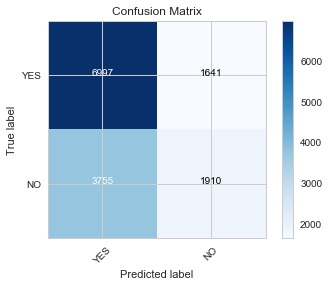

In [211]:
plot_cf(xgb_cf)

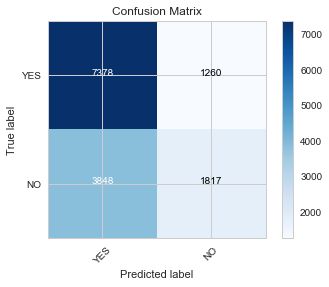

In [212]:
plot_cf(smote_cf)

In [253]:
print("XGB Predictions: \n", pd.Series(test_preds).value_counts()"n")

print("Smote Log Predictions: \n", pd.Series(smote_log_test_preds).value_counts())

XGB Predictions: 
 NO     10752
YES     3551
dtype: int64
Smote Log Predictions: 
 NO     11226
YES     3077
dtype: int64


In [104]:
y_test.value_counts()

NO     8638
YES    5665
Name: readmitted, dtype: int64

The confusion matrices show there are too many false negatives, and in this scenario, it would be best to see more false positives to err on the side of caution. 

### Cross Validation

In [106]:
# Initializing classifier with optimal parameters
clf = XGBClassifier(xgb__learning_rate= 0.2,
xgb__max_depth= 6,
xgb__min_child_weight= 2,
xgb__n_estimators= 100,
xgb__subsample= 0.5)

In [188]:
#Testing three CV levels
cv_5_results  = np.mean(cross_val_score(clf, smote_x_train, smote_y_train, cv=5,  scoring='f1_macro'))
cv_10_results = np.mean(cross_val_score(clf, smote_x_train, smote_y_train, cv=10, scoring='f1_macro'))
cv_20_results = np.mean(cross_val_score(clf,smote_x_train, smote_y_train, cv=20, scoring='f1_macro'))

In [206]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

0.5561295053734316
0.5916031333213192
0.5999093484392624


Cross validation indicates that as the data is folded into smaller and smaller subsets, modeled, and averaged, the f1 score only reaches to about 60%. Again, further confirming that the XGBoost model may be too complex and overfits. 

### ROC AUC

In [247]:
# Replacing categories with mathematically friendly binary codes instead of strings

yt = smote_y_train.replace('YES', 1)
yt = yt.replace('NO', 0)

ytest = y_test.replace('YES', 1)
ytest = ytest.replace('NO', 0)

In [251]:
# Calculating AUC
y_score = smote_log.fit(smote_x_train, yt).decision_function(x_test)

fpr, tpr, thresholds = roc_curve(ytest, y_score)
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.6648251624066324


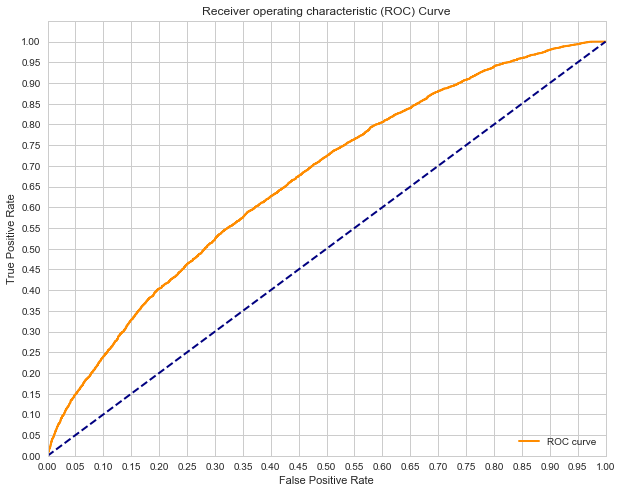

In [252]:
# Plotting the AUC
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Again, the ROC curve indicates that this model doesn't perform as well as hoped, and the trade off between false positives and true positives is not worth it. This visualization used the logistic regression model as opposed to the XGBoost in order to save time. 

# Next Steps

- More complex models

Notably missing from this project are Random Forests and Support Vector Machines. Unfortunately, the computational cost for these two models were far too high for a dataset such as this. With access to a more powerful computer with a GPU or TPU, this problem can easily be solved. 

- More descriptive data

This dataset is made almost entirely of categorical data. I believe that more descriptive data, such as numerical test results as opposed to categories such as low, medium, and high could offer deeper meaning that may be more easily interpreted by the classification models. 

- Better feature selection

On the other hand, the dataset could be far too complex. Identifying features which have little to no impact on the results could be removed. Even with PCA bringing the number of features down to 250 from 523 was not enough to make this dataset manageable for more complex models. 

- Poor interpretability

Principal Component Analysis (PCA) is a bit of a black box. Though it lowers run times, it strips the data of readable interpretability beyond the explained variance. 